
# Getting data from CDAWeb

*Really nice, much cleaner and faster than before, both downloading and importing. Now, introduce it into 1_compute_sfs, just noting annoying issue with variable names.

Using Sunpy to download data from CDAWeb using its Fido interface. To lookup the different dataset IDs available, you can use the form at https://cdaweb.gsfc.nasa.gov/index.html/
Tick the name of the spacecraft you want, hit submit, and you'll be a given a list of all the data products for that spacecraft. Copy and paste the name into the `a.cdaweb.Dataset("")` below, choose your time range `trange`, and you're away!

## Data download

In [2]:
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.timeseries import TimeSeries

In [3]:
# "WI_H2_MFI"
# "PSP_FLD_L2_MAG_RTN"
# "VOYAGER1_48S_MAG-VIM"

In [4]:
trange = a.Time("1996-10-15 00:00", "1996-10-16 00:00")
dataset = a.cdaweb.Dataset("WI_H2_MFI")
result = Fido.search(trange, dataset)
print(result)

Results from 1 Provider:

2 Results from the CDAWEBClient:
Source: https://cdaweb.gsfc.nasa.gov/index.html

 Dataset         Start time               End time       
--------- ----------------------- -----------------------
WI_H2_MFI 1996-10-15 00:00:00.000 1996-10-15 23:59:59.000
WI_H2_MFI 1996-10-16 00:00:00.000 1996-10-16 23:59:59.000




Datasets are 6-hourly

In [4]:
downloaded_files = Fido.fetch(result[0, 0:2], path="data/raw/voyager/")
print(downloaded_files)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

['C:\\Users\\spann\\data\\raw\\voyager\\voyager1_48s_mag-vim_20210101_v01.cdf']


## Data reading

In [5]:
data = TimeSeries(downloaded_files, concatenate=True)
data.columns

['BN',
 'BR',
 'BT',
 'F1',
 'dBN',
 'dBR',
 'dBT',
 'dF',
 'spacecraftID',
 'Radius',
 'hg_lat',
 'hg_lon',
 'hgi_lon']

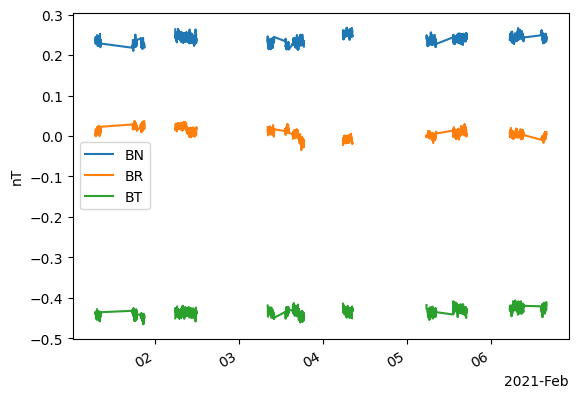

In [6]:
data.truncate("2021/02/01 00:00", "2021/02/07 00:00").peek(columns=data.columns[0:3])

In [7]:
df = data.to_dataframe()

# Calculate the cadence of the time series
cadence = df.index.to_series().diff().mode()[0]
cadence

Timedelta('0 days 00:00:47.520000')

In [8]:
df_res = df.resample(
    "50s"
).mean()  # This fixes the issue with the time series not being regular
df_res.head()

,BN,BR,BT,F1,dBN,dBR,dBT,dF,spacecraftID,Radius,hg_lat,hg_lon,hgi_lon
2021-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,151.419998,34.799999,70.900002,175.300003
2021-01-01 00:00:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:01:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:02:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:03:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
missing = df_res.iloc[:, 0].isna().sum() / len(df_res)
missing

0.7725760784220419

<Axes: >

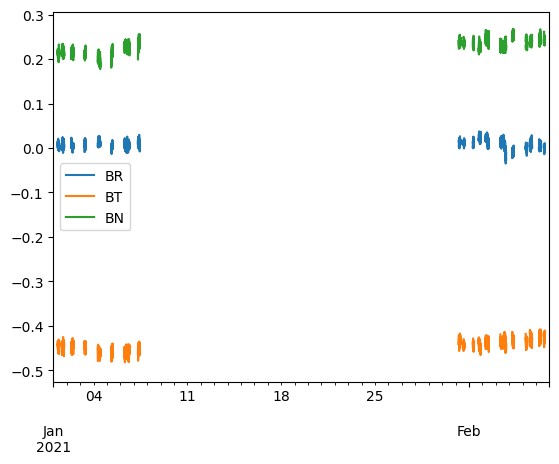

In [10]:
df_res[["BR", "BT", "BN"]][:"2021/02/07 00:00"].plot()